## Case Study: Chapter 6 - Rural Electrification with Microgrid

 Authors:    Neeraj Dhanraj Bokde (www.neerajbokde.in)
             and Carlo Fanara
             
 Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi
 
 Corresponding author: neeraj.bokde@tii.ae / neerajdhanraj@gmail.com

 Description:
   This script demonstrates scenario-based modeling of a rural microgrid using PyPSA,
   as described in Chapter 6 ("Microgrids and Distributed Energy Resources"). 
   The study evaluates the system’s performance under four configurations: 
   
           (1) Baseline (diesel + grid), 
           
           (2) Renewable energy integration (solar + wind), 
           
           (3) Conservative demand response (DR), and
           
           (4) Aggressive demand response. 
           
   Each scenario is constructed as a separate branch,
   ensuring reproducibility by copying the unsolved base network before optimization.

   The model uses real-world time series data for demand, solar irradiance, and wind
   generation, enabling realistic assessment of operational cost, renewable utilization,
   and CO2 emissions under different DER and demand-side management strategies.
   Results are visualized using comparative plots for load profiles, dispatch, KPIs,
   and scenario performance. This script is designed as a template for hands-on learning,
   benchmarking, or extension to more complex microgrid planning problems.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Microgrids and Distributed Energy Resources.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable
   Energy Modeling, Chapter 6.
   Publisher: Elsevier Science
   ISBN: 044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy
   - pandas
   - matplotlib
   - microgrid_input_timeseries_2020.csv (input data, see book appendix)

 License: MIT
 
 Version: 1.0
 
 Date: June 2025

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### Data Preparation

Load 5-day hourly time series (from OPSD, pre-filtered)

In [2]:
data = pd.read_csv(
    'microgrid_input_timeseries_2020.csv',
    parse_dates=['utc_timestamp'],
    index_col='utc_timestamp'
)

Select simulation window

In [3]:
start_date = '2020-01-01'
end_date = '2020-01-05'
filtered_data = data.loc[start_date:end_date]

Extract profiles for modeling

In [4]:
load_profile = filtered_data['load_MW'].values
solar_profile = filtered_data['solar_gen_MW'].values
wind_profile = filtered_data['wind_gen_MW'].values

#### Scenario 0: Build Baseline Network (DO NOT OPTIMIZE YET)

This network is the template. We will copy it before solving each scenario.

In [5]:
base_network = pypsa.Network()
snapshots = pd.date_range(start=start_date, periods=120, freq='h')
base_network.set_snapshots(snapshots)

base_network.add("Bus", "Microgrid Central Bus")

base_network.add("Load", "Microgrid Load",
                 bus="Microgrid Central Bus",
                 p_set=load_profile)

base_network.add("Generator", "Diesel Generator",
                 bus="Microgrid Central Bus",
                 p_nom=3000,
                 marginal_cost=100,
                 carrier="diesel",
                 efficiency=0.35)

base_network.add("Generator", "Grid Supply",
                 bus="Microgrid Central Bus",
                 p_nom=10000,
                 marginal_cost=150,
                 carrier="grid")

##### IMPORTANT: Copy the network BEFORE running optimize().

Each scenario must start from an *unsolved* network.

#### Scenario 1: Baseline (Diesel + Grid)

Copy the base network before solving

In [6]:
baseline_network = base_network.copy()
baseline_network.optimize(solver_name='glpk')

print("\n=== Scenario 1: Baseline (Diesel + Grid) ===")
print(f"Total system cost: {baseline_network.objective:.2f} $")
print("Diesel energy (MWh):", baseline_network.generators_t.p["Diesel Generator"].sum())
print("Grid energy (MWh):", baseline_network.generators_t.p["Grid Supply"].sum())

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.14s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 600 duals
Objective: 6.98e+07
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-y3jmttld.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-fyn3gqqm.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-y3jmttld.lp'...
600 rows, 240 columns, 720 non-zeros
3620 lines were read
GLPK Simplex Optimizer 5.0
600 rows, 240 columns, 720 non-zeros
Preprocessing...
~     0: obj =   6.979395000e+07  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.3 Mb (363636 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-fyn3gqqm.sol'...

=== Scenario 1: Baseline (Diesel + Grid) ===
Total system cost: 69793950.00 $
Diesel energy (MWh): 360000.0
Grid energy (MWh): 225293.0


#### Scenario 2: Renewable Integration (Solar + Wind)

Copy the base network BEFORE optimization for a clean scenario branch

In [7]:
re_network = base_network.copy()

Add renewable generators using real profiles

In [8]:
re_network.add("Generator", "Solar PV",
               bus="Microgrid Central Bus",
               p_nom=1000,
               marginal_cost=10,
               carrier="solar",
               p_max_pu=solar_profile / max(solar_profile),
               capital_cost=600)

re_network.add("Generator", "Wind Turbine",
               bus="Microgrid Central Bus",
               p_nom=1500,
               marginal_cost=12,
               carrier="wind",
               p_max_pu=wind_profile / max(wind_profile),
               capital_cost=800)

re_network.optimize(solver_name='glpk')

print("\n=== Scenario 2: Renewable Integration ===")
print(f"Total system cost: {re_network.objective:.2f} $")
print("Solar energy (MWh):", re_network.generators_t.p["Solar PV"].sum())
print("Wind energy (MWh):", re_network.generators_t.p["Wind Turbine"].sum())
print("Diesel energy (MWh):", re_network.generators_t.p["Diesel Generator"].sum())
print("Grid energy (MWh):", re_network.generators_t.p["Grid Supply"].sum())

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 480 primals, 1080 duals
Objective: 5.35e+07
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-_zvvf5wl.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-xgwq8beq.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-_zvvf5wl.lp'...
1080 rows, 480 columns, 1440 non-zeros
6740 lines were read
GLPK Simplex Optimizer 5.0
1080 rows, 480 columns, 1440 non-zeros
Preprocessing...
22 rows, 51 columns, 51 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 22
      0: obj =   5.613390612e+07 inf =   2.436e+04 (22)
     22: obj =   5.735195612e+07 inf =   0.000e+00 (0)
*    73: obj =   5.350916422e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.7 Mb (698004 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linop

#### Scenario 3: Demand Response (Conservative & Aggressive)

Extract dispatch results for DR baseline

In [9]:
initial_load = base_network.loads_t.p_set["Microgrid Load"]

For DR logic, use the renewable system's dispatch

In [10]:
solar_gen = re_network.generators_t.p["Solar PV"]
wind_gen = re_network.generators_t.p["Wind Turbine"]

combined_gen = solar_gen + wind_gen
threshold = combined_gen.quantile(0.75)

Demand Response adjustment profiles

In [11]:
dr_adj_cons = combined_gen.apply(lambda x: 1.1 if x > threshold else 0.9)
dr_adj_aggr = combined_gen.apply(lambda x: 1.2 if x > threshold else 0.8)

Create new load profiles

In [12]:
load_cons = initial_load * dr_adj_cons.values
load_aggr = initial_load * dr_adj_aggr.values

Conservative DR scenario

In [13]:
conservative_network = base_network.copy()

Add renewables as before

In [14]:
conservative_network.add("Generator", "Solar PV",
                         bus="Microgrid Central Bus",
                         p_nom=1000,
                         marginal_cost=10,
                         carrier="solar",
                         p_max_pu=solar_profile / max(solar_profile),
                         capital_cost=600)
conservative_network.add("Generator", "Wind Turbine",
                         bus="Microgrid Central Bus",
                         p_nom=1500,
                         marginal_cost=12,
                         carrier="wind",
                         p_max_pu=wind_profile / max(wind_profile),
                         capital_cost=800)

Update the load profile for DR

In [15]:
conservative_network.loads_t.p_set["Microgrid Load"] = load_cons

conservative_network.optimize(solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 480 primals, 1080 duals
Objective: 4.93e+07
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-37o1hd62.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-d96l40qh.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-37o1hd62.lp'...
1080 rows, 480 columns, 1440 non-zeros
6740 lines were read
GLPK Simplex Optimizer 5.0
1080 rows, 480 columns, 1440 non-zeros
Preprocessing...
23 rows, 48 columns, 48 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 23
      0: obj =   5.157656067e+07 inf =   1.723e+04 (23)
     23: obj =   5.243782067e+07 inf =   0.000e+00 (0)
*    71: obj =   4.932846204e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.7 Mb (697996 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linop

('ok', 'optimal')

Aggressive DR scenario

In [16]:
aggressive_network = base_network.copy()
aggressive_network.add("Generator", "Solar PV",
                       bus="Microgrid Central Bus",
                       p_nom=1000,
                       marginal_cost=10,
                       carrier="solar",
                       p_max_pu=solar_profile / max(solar_profile),
                       capital_cost=600)
aggressive_network.add("Generator", "Wind Turbine",
                       bus="Microgrid Central Bus",
                       p_nom=1500,
                       marginal_cost=12,
                       carrier="wind",
                       p_max_pu=wind_profile / max(wind_profile),
                       capital_cost=800)
aggressive_network.loads_t.p_set["Microgrid Load"] = load_aggr

aggressive_network.optimize(solver_name='glpk')

print("\n=== Scenario 3: Demand Response ===")
print("Conservative DR - System cost: {:.2f} $".format(conservative_network.objective))
print("Aggressive DR   - System cost: {:.2f} $".format(aggressive_network.objective))

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.14s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 480 primals, 1080 duals
Objective: 4.56e+07
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-q0l61ay9.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-wsbn8zp0.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-q0l61ay9.lp'...
1080 rows, 480 columns, 1440 non-zeros
6740 lines were read
GLPK Simplex Optimizer 5.0
1080 rows, 480 columns, 1440 non-zeros
Preprocessing...
42 rows, 95 columns, 95 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 42
      0: obj =   4.921493774e+07 inf =   1.939e+04 (42)
     42: obj =   5.018421774e+07 inf =   0.000e+00 (0)
*   137: obj =   4.564277317e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.7 Mb (698260 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linop

#### Visualization: Load Profiles

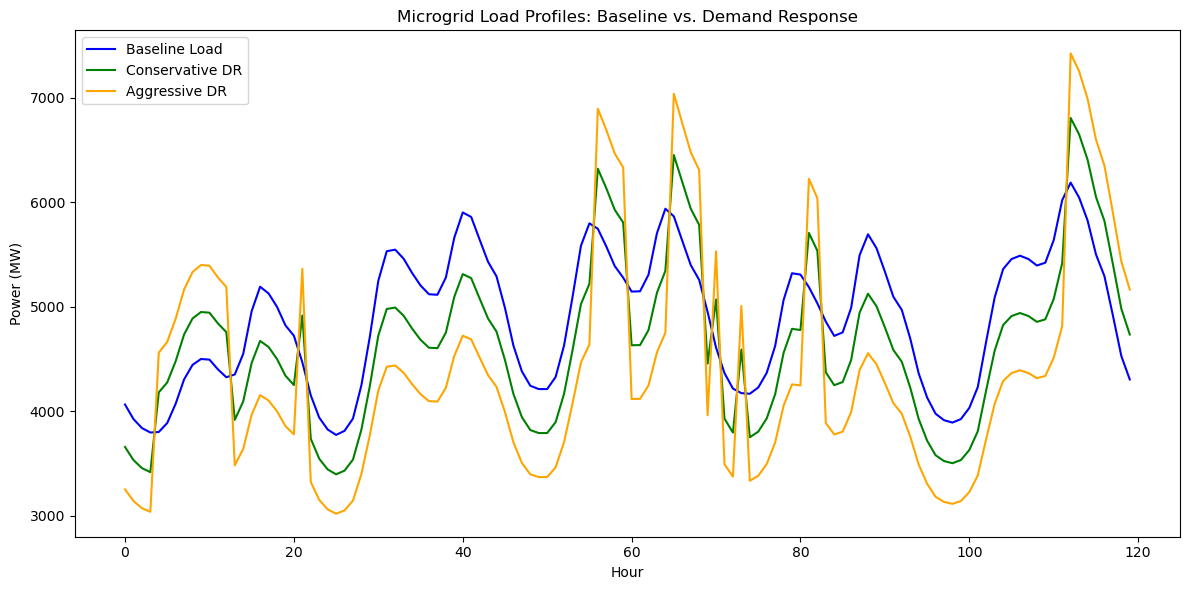

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(initial_load.values, label='Baseline Load', color='blue')
plt.plot(load_cons.values, label='Conservative DR', color='green')
plt.plot(load_aggr.values, label='Aggressive DR', color='orange')
plt.title('Microgrid Load Profiles: Baseline vs. Demand Response')
plt.xlabel('Hour')
plt.ylabel('Power (MW)')
plt.legend()
plt.tight_layout()
plt.show()

#### Visualization: Generation Dispatch (All Scenarios)

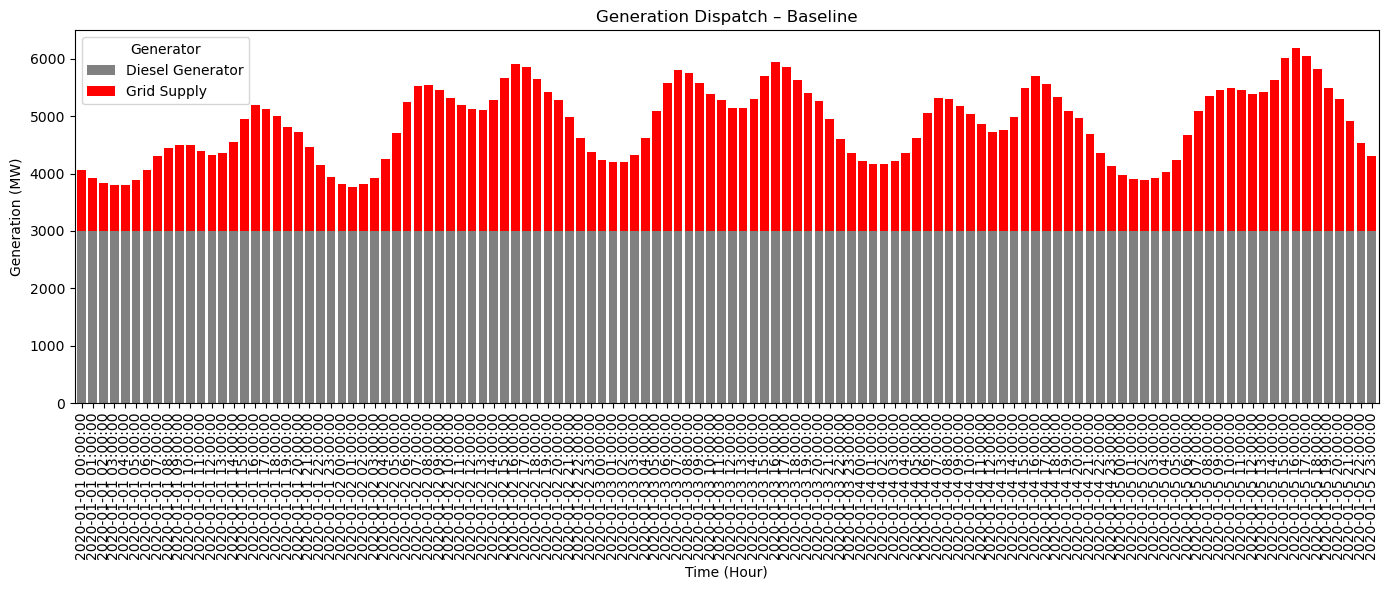

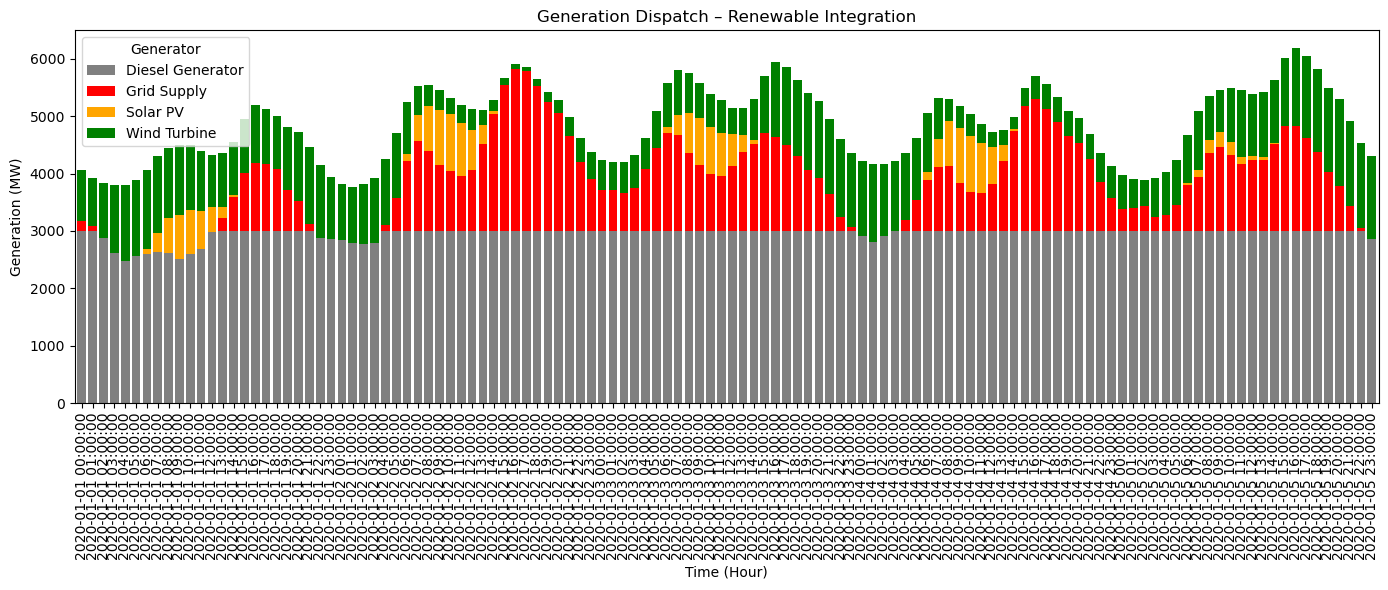

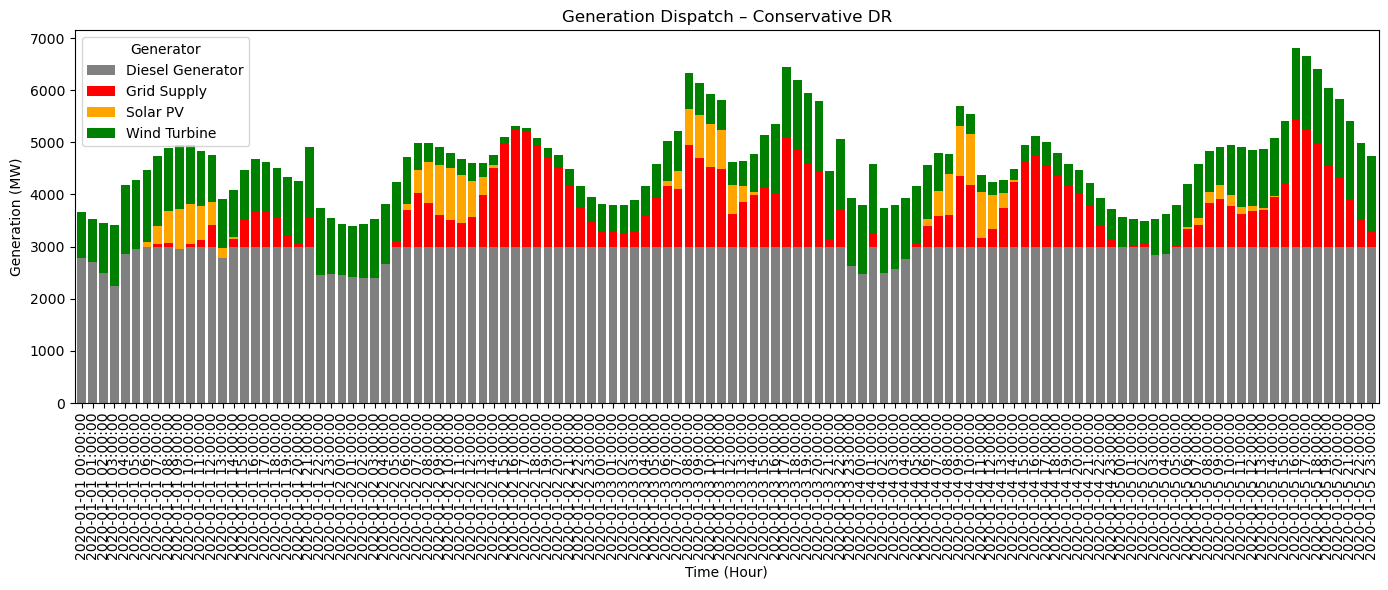

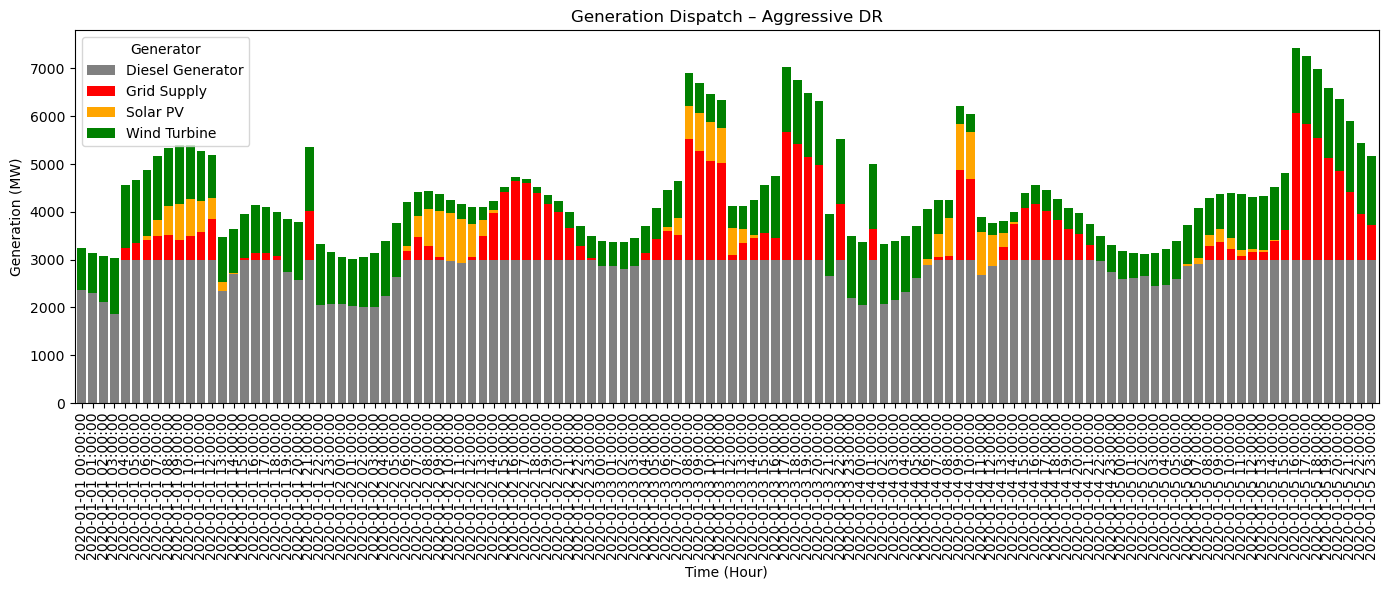

In [18]:
def plot_dispatch(network, title):
    gen_dispatch = network.generators_t.p
    colors = {
        'Diesel Generator': 'grey',
        'Grid Supply': 'red',
        'Solar PV': 'orange',
        'Wind Turbine': 'green'
    }
    gen_dispatch.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 6),
        color=[colors.get(gen, 'black') for gen in gen_dispatch.columns],
        width=0.8
    )
    plt.title(title)
    plt.xlabel("Time (Hour)")
    plt.ylabel("Generation (MW)")
    plt.legend(title="Generator")
    plt.tight_layout()
    plt.show()

plot_dispatch(baseline_network, "Generation Dispatch – Baseline")
plot_dispatch(re_network, "Generation Dispatch – Renewable Integration")
plot_dispatch(conservative_network, "Generation Dispatch – Conservative DR")
plot_dispatch(aggressive_network, "Generation Dispatch – Aggressive DR")

#### KPIs: Renewable Utilization, Cost, Emissions

Renewable utilization ratios

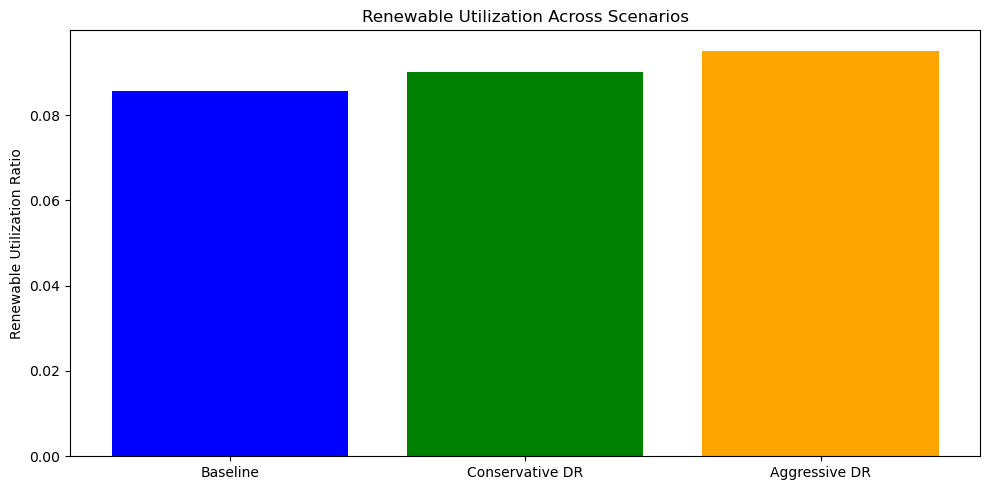

In [19]:
total_RE = solar_profile.sum() + wind_profile.sum()
consumption_baseline = initial_load.sum()
consumption_cons = load_cons.sum()
consumption_aggr = load_aggr.sum()

utilization_baseline = total_RE / consumption_baseline
utilization_cons = total_RE / consumption_cons
utilization_aggr = total_RE / consumption_aggr

plt.figure(figsize=(10, 5))
plt.bar(['Baseline', 'Conservative DR', 'Aggressive DR'],
        [utilization_baseline, utilization_cons, utilization_aggr],
        color=['blue', 'green', 'orange'])
plt.ylabel('Renewable Utilization Ratio')
plt.title('Renewable Utilization Across Scenarios')
plt.tight_layout()
plt.show()

Economic KPI (total operational cost)

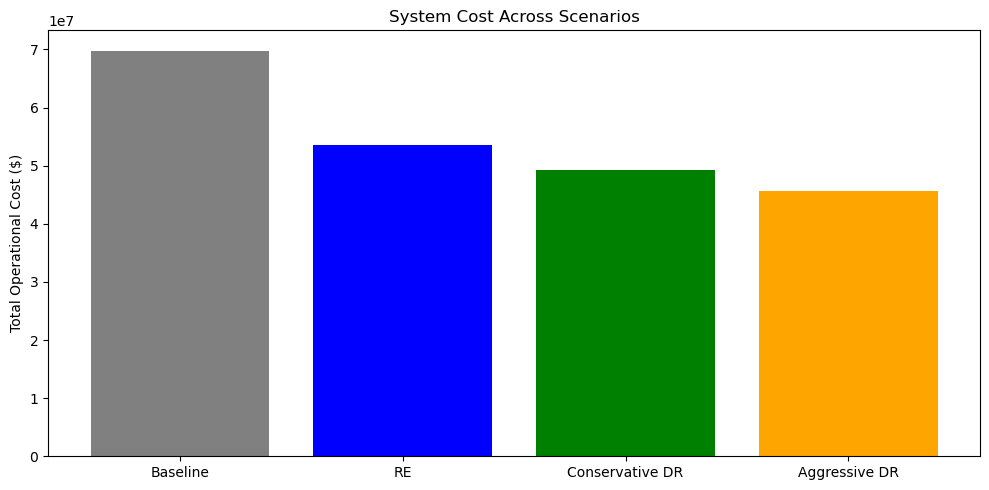

In [20]:
costs = [
    baseline_network.objective,
    re_network.objective,
    conservative_network.objective,
    aggressive_network.objective
]
plt.figure(figsize=(10, 5))
plt.bar(['Baseline', 'RE', 'Conservative DR', 'Aggressive DR'], costs,
        color=['grey', 'blue', 'green', 'orange'])
plt.ylabel('Total Operational Cost ($)')
plt.title('System Cost Across Scenarios')
plt.tight_layout()
plt.show()

Emissions: 0.7 tons/MWh for diesel, 0.5 for grid

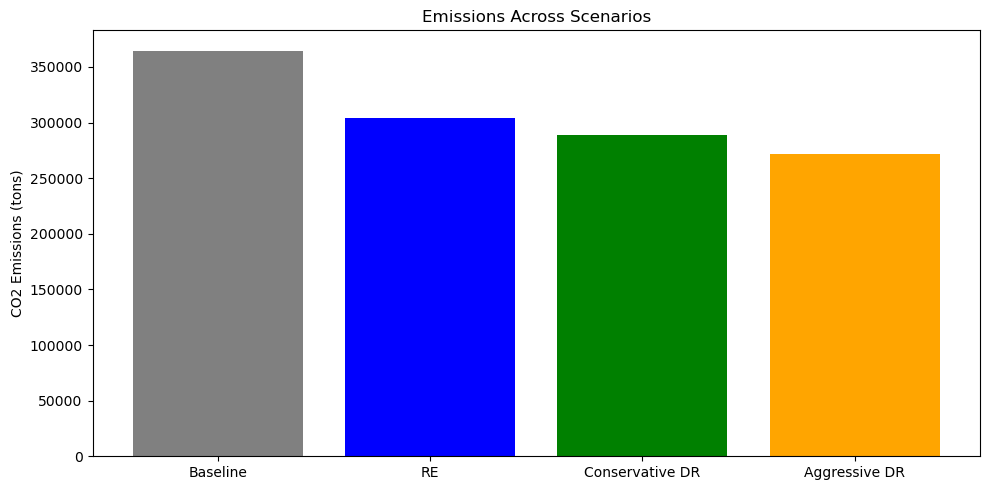


=== KPI Summary ===
Renewable Utilization (Baseline):    0.09
Renewable Utilization (Cons. DR):    0.09
Renewable Utilization (Aggr. DR):    0.10
System Cost (Baseline):              69793950.00 $
System Cost (Cons. DR):              49328462.04 $
System Cost (Aggr. DR):              45642773.17 $
Emissions (Baseline):                364646.50 tons
Emissions (Cons. DR):                288731.30 tons
Emissions (Aggr. DR):                271745.98 tons


In [21]:
def calculate_emissions(network):
    em = 0
    for gen in network.generators.index:
        if network.generators.carrier[gen] == "diesel":
            em += network.generators_t.p[gen].sum() * 0.7
        elif network.generators.carrier[gen] == "grid":
            em += network.generators_t.p[gen].sum() * 0.5
    return em

emissions = [
    calculate_emissions(baseline_network),
    calculate_emissions(re_network),
    calculate_emissions(conservative_network),
    calculate_emissions(aggressive_network)
]
plt.figure(figsize=(10, 5))
plt.bar(['Baseline', 'RE', 'Conservative DR', 'Aggressive DR'], emissions,
        color=['grey', 'blue', 'green', 'orange'])
plt.ylabel('CO2 Emissions (tons)')
plt.title('Emissions Across Scenarios')
plt.tight_layout()
plt.show()

print("\n=== KPI Summary ===")
print(f"Renewable Utilization (Baseline):    {utilization_baseline:.2f}")
print(f"Renewable Utilization (Cons. DR):    {utilization_cons:.2f}")
print(f"Renewable Utilization (Aggr. DR):    {utilization_aggr:.2f}")
print(f"System Cost (Baseline):              {costs[0]:.2f} $")
print(f"System Cost (Cons. DR):              {costs[2]:.2f} $")
print(f"System Cost (Aggr. DR):              {costs[3]:.2f} $")
print(f"Emissions (Baseline):                {emissions[0]:.2f} tons")
print(f"Emissions (Cons. DR):                {emissions[2]:.2f} tons")
print(f"Emissions (Aggr. DR):                {emissions[3]:.2f} tons")

### End of Microgrid Case Study (Chapter 6)